In [32]:
import pickle
import datetime
from numpy import array
import matplotlib.pylab as plt
import pandas as pd
import covsirphy as cs
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
# Download datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()
oxcgrt_data = data_loader.oxcgrt()

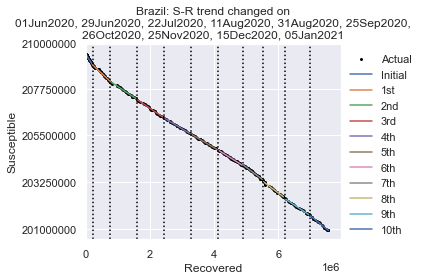


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...
	 6th phase (25Sep2020 - 25Oct2020): finished  383 trials in 0 min 30 sec
	 2nd phase (05Jan2021 - 19Jan2021): finished  497 trials in 1 min  0 sec
	 0th phase (25Nov2020 - 14Dec2020): finished  500 trials in 1 min  0 sec
	 5th phase (29Jun2020 - 21Jul2020): finished 1288 trials in 3 min  1 sec
	 4th phase (15Mar2020 - 31May2020): finished 1266 trials in 3 min  2 sec
	 1st phase (01Jun2020 - 28Jun2020): finished 1295 trials in 3 min  2 sec
	 8th phase (31Aug2020 - 24Sep2020): finished  267 trials in 0 min 30 sec
	10th phase (15Dec2020 - 04Jan2021): finished 1299 trials in 3 min  2 sec
	 3rd phase (11Aug2020 - 30Aug2020): finished 1489 trials in 3 min  2 sec
	 7th phase (26Oct2020 - 24Nov2020): finished 1493 trials in 3 min  2 sec
	 9th phase (22Jul2020 - 10Aug2020): finished 1685 trials in 3 min  1 sec
Completed optimization. Total: 7 min  6 sec
School_closing {'theta': 0.02464773853948918, 'kappa': 0.000579521269

In [43]:
countries = ["Brazil"]
for country in countries:
    s = cs.Scenario(jhu_data, population_data, country=country)
    days, df_periods = s.estimate_delay(oxcgrt_data)

    s.trend()
    s.estimate(cs.SIRF)
    tracker = s.track()
    tracker = tracker.set_index("Date")
    tracker = tracker.groupby("Date").mean()
    tracker = tracker.shift(days)
    ox_df = oxcgrt_data.cleaned()
    ox_df = ox_df[ox_df["Country"] == country]
    ox_df = ox_df.groupby("Date").mean()
    merged = pd.merge(ox_df.reset_index(), tracker.reset_index(), on="Date", how="inner")

    measures = ox_df.columns
    interests = ["theta", "kappa", "rho", "sigma", "1/gamma [day]", "alpha1 [-]",  "1/alpha2 [day]", "1/beta [day]", "Measure"]
    params_total = pd.DataFrame(columns=interests)

    for i in range(len(measures)):
        measure = measures[i]
        values = ox_df[measure].values
        high = np.max(values)
        dates = ox_df[ox_df[measure] == high].reset_index()["Date"]
        subset = tracker.reset_index()[tracker.reset_index()["Date"].isin(dates)]
        means_df = subset.mean()[interests[:-1]]
        means_df["Measure"] = measure
        params_total.loc[i] = means_df
    params_total = params_total.set_index("Measure")
    params_total = params_total.reset_index()

    all_infecteds = pd.DataFrame()
    target = "Infected"
    measures_new = ['School_closing', 'Workplace_closing', 'Cancel_events',
           'Gatherings_restrictions', 'Transport_closing',
           'Stay_home_restrictions', 'Internal_movement_restrictions',
           'International_movement_restrictions']

    for measure in measures_new:
        name = measure
        selection = params_total[params_total["Measure"] == name]
        preset_dict = {
            "theta": selection["theta"].values[0],
            "kappa": selection["kappa"].values[0],
            "sigma": selection["sigma"].values[0],
            "rho": selection["rho"].values[0]
        }
        print(measure, preset_dict)
        s.summary()

        s.clear(name=name)
        s.add(name=name, 
              end_date='01Mar2021',
              **preset_dict,
              mode=cs.SIRF)
        records = s.simulate(name=name, show_figure=False)
        all_infecteds[measure] = records[target]

    all_infecteds["Date"] = records["Date"]
    all_infecteds.to_pickle("figures/pickles/" + country + "measures")
    all_infecteds_subsection = all_infecteds.query("Date>='2021-01-01'")